In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import absolute_import

In [2]:
from extract_data import *
from finbeat_calc import *
from plot_track import *
from plot_accel import *
from check_plots import *
import pywt
import pylab
import numpy as np

# Take position data from hardcoded folder, calc. velocities, accels
tracklist = extract_data()

# Calculate finbeat peaks and troughs

finbeats, finbeat_byP, finbeat_byT = finbeat_calc(tracklist.keys(), tracklist)

# Extract finbeat periods, amplitudes, and subsequent accel

# Plot things if desired
# plot_track(['sometrial'], tracklist)
# plot_accel(['sometrial'], tracklist)

# """If you want to plot the peaks and troughs on the position data,
# uncomment section in finbeat_calc"""

C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\

In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

def plot_analysis(subset_name, finbeats_subset, finbeat_info):
    """
    Args:
        subset_name (string): some string identifying what's in your
                                subset, to be used as plot title
        finbeats_subset (list): a list of strings with the trial
                            names of the desired trials from finbeats.
                             Note: The list (even of a single
                             element) must be contained in square
                             brackets.
                             Also note: You'll probably want to use
                             one of the subset generating functions,
                             make_fish_subset() or make_sp_subset()
        finbeat_info (dict): choose either finbeat_byP to do analysis
                            on finbeats as defined by peaks first,
                            or finbeat_byT to use finbeats defined by
                            troughs first. Default is _byP.

    Returns:
        finbeats[trial_name] (dict):
    """
    count_n = 0
    
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    fig.suptitle(subset_name)
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    ax1.set_xlabel('Period (s)')
    ax1.set_ylabel('Amplitude (cm)')
    ax1.set_zlabel('Maximum Accel (cm/s2)')

    # for each trial of interest
    for trial in finbeats_subset:
        # for each finbeat within that trial
        for finbeat in finbeat_info[trial].index.values:
            # get the period
            #period_mask = finbeat_info[trial]['period'].loc[finbeat]
            period = finbeat_info[trial]['period'][finbeat]

            # get the amplitude
            #amplitude_mask = finbeat_info[trial]['amplitude'].loc[
                #finbeat]
            amplitude = finbeat_info[trial]['amplitude'][finbeat]

            # get the start time
            #start_mask = finbeat_info[trial]['time'].loc[finbeat]
            start = finbeat_info[trial]['time'][finbeat]
            # get the end time
            #end_mask = finbeat_info[trial]['endtime'].loc[finbeat]
            end = finbeat_info[trial]['endtime'][finbeat]

            # find the maximum acceleration in that time range
            accel = tracklist[trial]['data'][
                          'pt1_net_a'][start:end].max()

            # add the point
            ax1.scatter3D(xs=period,
                          ys=amplitude,
                          zs= accel,
                          zdir='z', s=20, marker='o', c='black', edgecolor='none')
            count_n +=1
            
    plt.show()
    print(count_n)

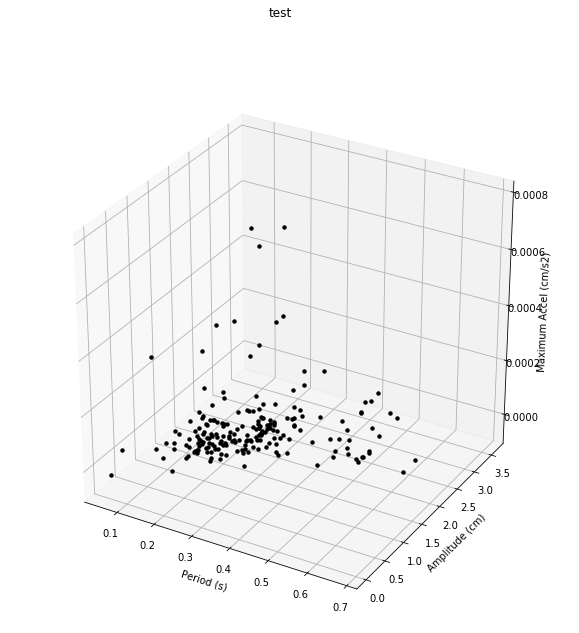

254


In [27]:
plot_analysis("test",tracklist.keys(), finbeat_byP)

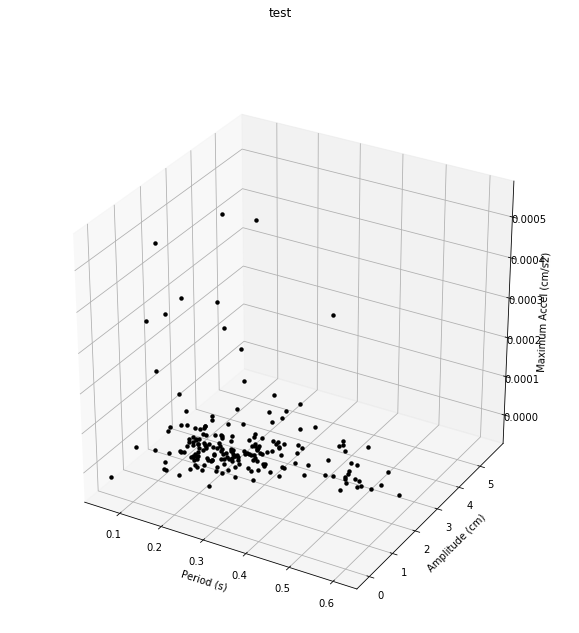

250


In [28]:
plot_analysis("test",tracklist.keys(), finbeat_byT)

In [ ]:
tracklist_subset = ['Bass1S12', 'Bass1S09', 'Bass1S06']


for trial in tracklist_subset:
    data = tracklist[trial]['data']['pt2y_smth']
    length = data.size
    FR = tracklist[trial]['FPS']
    sampling = 1.0/FR
    x = pylab.arange(0, 1, 1. / length)

    cA = []
    cD = []

    (cA, cD) = pywt.dwt(data,'sym20')

    pylab.title(trial)
    pylab.imshow((cA,cD), extent=[-1, 1, 1, 31], cmap='bone', aspect='auto') 
    pylab.show()


